In [1]:
import drjit as dr
import mitsuba as mi
mi.set_variant("cuda_ad_rgb")

import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from mitsuba.python.ad.integrators.common import ADIntegrator,mis_weight
from tqdm import tqdm   # 显示进度条的库
from kan import *

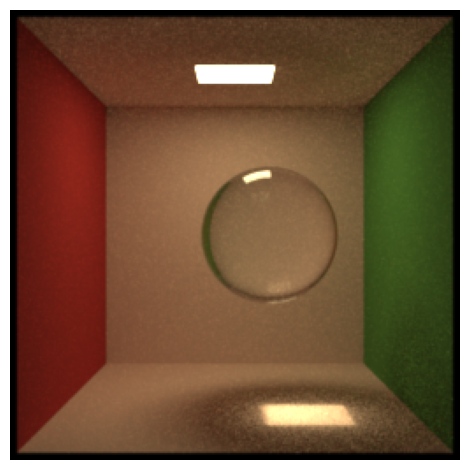

In [2]:
# Harder scene
# To change the order so that the declaration of glass BSDF occurs before the reference of it, we need to use the `pop` function.
scene_dict = mi.cornell_box()
scene_dict.pop("small-box")
scene_dict.pop("large-box")
scene_dict["glass"] = {"type": "dielectric"}
scene_dict["ball"] = {
    "type": "sphere",
    "to_world": mi.ScalarTransform4f.scale([0.4, 0.4, 0.4]).translate([0.5, 0, 0.5]),
    "bsdf": {"type": "ref", "id": "glass"}
}
#试了一下带有介质的球
# scene_dict['ball'] = {
#     'type':'sphere',
#     "to_world": mi.ScalarTransform4f.scale([0.4, 0.4, 0.4]).translate([0.5, 0, 0.5]),
#     "medium":{'type':'homogeneous','albedo':{'type':'rgb','value':[0.6,0.7,0.5]}, 'sigma_t':{'type':'rgb', 'value':[0.5,0.25,0.2]}, 'phase':{'type':'hg','g':0.3}}
# }

scene = mi.load_dict(scene_dict)
original_image = mi.render(scene, spp=1024)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(original_image ** (1.0 / 2.2), 0, 1))

## 在网格表面均匀采样（在表面空间均匀采样）
- 根据面积大小选中一个mesh
- 在mesh上均匀采样 

In [3]:
m_area = [] # 存储各个shape的面积，如果某个shape是emitter或者delta分布的bsdf则不对其进行采样，将面积设为0
for shape in scene.shapes():
    if not shape.is_emitter() and mi.has_flag(shape.bsdf().flags(),mi.BSDFFlags.Smooth):
        m_area.append(shape.surface_area())
    else:
        m_area.append([0])
    
# m_area原始形状是 [[val],[val],[val],[val] ...] ,将其转换为 [val,val,val,val ...]
m_area = np.array(m_area)[:,0]

if len(m_area) > 0:
    m_area /= m_area.sum()  # 转化为概率
else:
    raise Warning("没有可以采样的shape!")


有了采样所有shape的概率之后，利用离散分布来对这一组概率进行采样

In [4]:
shape_sampler =  mi.DiscreteDistribution(m_area)  # 根据m_area创建一维离散概率分布,用于后续采样

def sample_si(scene,shape_sampler,sample1,sample2,sample3,active=True):
    """ 在表面上采样一个训练批次大小的样本点
        Args:
            scene: 场景
            shape_sampler: 采样shape用的采样器(一维离散分布)
            sample1(mi.Float): 采样shape
            sample2(mi.Point2f): 在shape上采样点
            sample3(mi.Point2f): 在采样点上采样方向
        Returns:
            mi.SurfaceInteraction3f
    """
    selected_shape = shape_sampler.sample(sample1,active) # 返回被选中的shape的下标
    shapes = dr.gather(mi.ShapePtr,scene.shapes_dr(),selected_shape,active)    # 获取选中的shape
    ps = shapes.sample_position(time=0,sample=sample2,active=active)    # 在物体表面选取样本点
    si = mi.SurfaceInteraction3f(ps, dr.zeros(mi.Color0f))   # 转换成si
    si.shape = shapes   # shapes中包含了bsdf可以查询
    si.t = mi.Float(si.time*0)
    # 如果背面也可以采样光线，就在整个单位球上采样，否则就只在半球采样
    active_both_size = mi.has_flag(si.bsdf().flags(),mi.BSDFFlags.BackSide)
    si.wi = dr.select(
        active_both_size,
        mi.warp.square_to_uniform_sphere(sample3),
        mi.warp.square_to_uniform_hemisphere(sample3)
    )
    return si





In [5]:
l_sampler = mi.load_dict({"type":"independent","sample_count":1})
r_sampler = mi.load_dict({"type":"independent","sample_count":1})

# 训练配置
batch_size = 2**14
M = 32
total_steps = 1000
lr = 5e-4
seed = 42

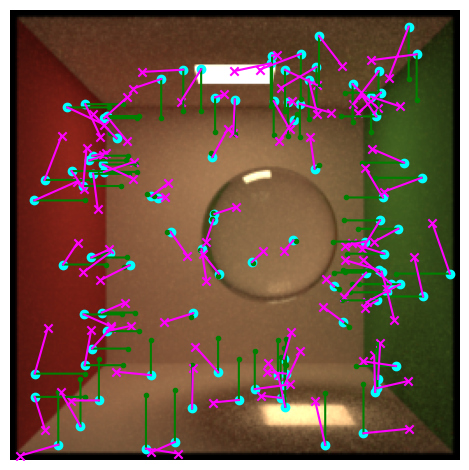

In [6]:
def world_to_ndc(scene,batch):
    """将世界坐标转化到标准化设备空间
    """
    sensor = mi.traverse(scene.sensors()[0])    # 将相机的相关参数都转化为dic的形式
    trafo = mi.Transform4f.perspective(fov=sensor['x_fov'],near=sensor['near_clip'],far=sensor['far_clip']) # 构建透视变换矩阵
    pts = trafo@sensor['to_world'].inverse()@mi.Point3f(np.array(batch))    # 传入的坐标集合做如下变换：世界空间 ---> 相机空间 ---> 透视投影变换到NDC
    return pts

def ndc_to_pixel(pts, h, w):
    """Converts points in NDC to pixel coordinates.

    Args:
        pts (mi.Point2f): Points in NDC.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.

    Returns:
        mi.Point2f: Pixel coordinates of the given points.
    """
    hh, hw = h/2, w/2
    return mi.Point2f(dr.fma(pts.x, -hw, hw), dr.fma(pts.y, -hw, hh))  # not typo

def draw_multi_segments(starts, ends, color):   
    """绘制线段

    Args:
        starts (mi.Point2f): Starting points of the line segments.
        ends (mi.Point2f): Ending points of the line segments.
        color (str): Color of the line segments.
    """
    a = np.c_[starts.x, starts.y]
    b = np.c_[ends.x, ends.y]
    plt.plot(*np.c_[a, b, a*np.nan].reshape(-1, 2).T, color)

def pix_coord(scene, batch, h, w):
    """计算给定三维坐标的像素坐标

    Args:
        scene (mi.Scene): Mitsuba 3 scene containing the camera information.
        batch (array_like): Array of 3D world coordinates.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.

    Returns:
        mi.Point2f: Pixel coordinates of the given 3D world coordinates.
    """
    return ndc_to_pixel(world_to_ndc(scene, batch), h, w)
    
def draw_si(si,ax,original_image,marker=".",color="red"):
    h,w = original_image.shape[0],original_image.shape[1]
    x_pix = pix_coord(scene,si.p,h,w)
    wi_pix = pix_coord(scene, dr.fma(si.to_world(si.wi), 0.25, si.p), h, w)
    n_pix = pix_coord(scene, dr.fma(si.n, 0.25, si.p), h, w)
    draw_multi_segments(x_pix,n_pix,'green')    #采样点处的法线画成绿色
    draw_multi_segments(x_pix,wi_pix,color="magenta")   #wi方向画成粉色
    ax.scatter(x_pix.x,x_pix.y,marker=marker,color=color)
    plt.scatter(n_pix.x,n_pix.y,marker='.',color="green")
    plt.scatter(wi_pix.x,wi_pix.y,marker='x',color="magenta")
    ax.imshow(np.clip(original_image**(1.0/2.2),0,1))

def draw_moving_arrow(si, h, w, si_prev, ax):
    """Draws a moving arrow on a plot to represent the surface interaction movement.

    Args:
        si (mi.SurfaceInteraction): Surface interaction to be drawn.
        h (float): Height of the image in pixels.
        w (float): Width of the image in pixels.
        si_prev (mi.SurfaceInteraction): Previous surface interaction to connect to the current one.
        ax (matplotlib.axes.Axes): The axes object to plot the moving arrow on.
    """
    x_pix = pix_coord(scene, si.p, h, w)
    x_prev_pix = pix_coord(scene, si_prev.p, h, w)
    draw_multi_segments(x_prev_pix, x_pix, 'green')

l_sampler = l_sampler.clone()
l_sampler.seed(seed,100)  #采样5个点

si = sample_si(scene,shape_sampler,l_sampler.next_1d(),l_sampler.next_2d(),l_sampler.next_2d())
fig,ax = plt.subplots() #fig:绘图容器，ax:具体绘图的区域
fig.patch.set_visible(False)
ax.axis('off')
fig.tight_layout()
draw_si(si,ax,original_image,marker='o',color="cyan")



In [7]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

Allocated: 0.00 MB
Cached: 0.00 MB


In [ ]:
from tinycudann import Encoding as NGPEncoding

class NRFeild(torch.nn.Module):
    def __init__(self,bb_min,bb_max):
        """ 初始化NRField实例
        Args:
            bb_min (mi.ScalarBoundingBox3f): 包围盒的minPoint
            bb_max (mi.ScalarBoundingBox3f): 包围盒的maxPoint
        """
        super().__init__()
        self.bb_min = bb_min
        self.bb_max = bb_max
        enc_config = {
            "otype":"HashGrid",
            "base_resolution":16,
            "n_levels":8,
            "n_fatures_per_level":4,
            "log2_hashmap_size":22
        }
        self.pos_enc = NGPEncoding(3,enc_config)
        # 神经网络
        in_features = 3*4 + self.pos_enc.n_output_dims
        n_neurons = 256
        layers = [
            torch.nn.Linear(in_features,n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons,n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons,n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons,n_neurons),
            torch.nn.ReLU(),
            torch.nn.Linear(n_neurons,3)
            # FastKANLayer(16,16),
            # FastKANLayer(16,16),
            # FastKANLayer(16,3)
        ]
        self.rgb_net = torch.nn.Sequential(*layers)
    
    def forward(self,si):
        with dr.suspend_grad():
            x = ( (si.p - self.bb_min)/(self.bb_max-self.bb_min) ).torch()  # 整个场景都在一个大的包围盒内，每一个点都可以计算成在盒子内的相对坐标
            n = si.sh_frame.n.torch()
            wi = si.to_world(si.wi).torch()
            # 获取方向无关的albedo
            si_view = mi.SurfaceInteraction3f(si)
            si_view.wi = mi.Point3f([0.353553, 0.353553, 0.866025])
            f_d = si_view.bsdf().eval_diffuse_reflectance(si_view).torch()
        z_x = self.pos_enc(x)
        input = torch.cat([x,wi,n,f_d,z_x],dim=1)
        output = self.rgb_net(input)
        output = torch.abs(output)
        return output.to(torch.float32)

def get_camera_first_bounce(scene):
    cam_origin = mi.Point3f(0, 1, 3)
    cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))
    cam_width = 2.0
    cam_height = 2.0
    image_res = [256, 256]

    x, y = dr.meshgrid(
        dr.linspace(mi.Float, -cam_width / 2, cam_width / 2, image_res[0]),
        dr.linspace(mi.Float, -cam_height / 2, cam_height / 2, image_res[1]),
    )
    ray_origin_local = mi.Vector3f(x, y, 0)
    ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin
    ray = mi.Ray3f(o=ray_origin, d=cam_dir)
    si = scene.ray_intersect(ray)

    return si, image_res


In [9]:
field = NRFeild(scene.bbox().min,scene.bbox().max).cuda()
si,image_res = get_camera_first_bounce(scene)
res = field(si)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\RTProject\.conda\envs\mitsuba\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\RTProject\.conda\envs\mitsuba\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\RTProject\.conda\envs\mitsuba\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  Fi

RuntimeError: mat1 and mat2 shapes cannot be multiplied (65536x16 and 256x256)

In [ ]:
import time
def render_lhs(scene,model,si):
    with dr.suspend_grad():
        Le = si.emitter(scene).eval(si)
        null_face = ~mi.has_flag(si.bsdf().flags(),mi.BSDFFlags.BackSide) & (si.wi.z<0)   # wi位于局部坐标,法线是z轴正方向，如果si.wi.z<0说明方向指向物体内部
        mask = si.is_valid()&~null_face
        out = model(si)
        L = Le + dr.select(mask,mi.Spectrum(out),0)
    return L,Le,out,mask



In [ ]:
def get_none_specular_or_null_si(scene,si,sampler):
    """ 计算第一个非镜面交点
    Args:
        scene:场景
        si:采样点
        sampler:采样器
    Returns:
        si:更新后的采样点
        beta:路径权重乘积
        null_face:是否为无效交点
    """
    with dr.suspend_grad():
        max_depth = 10
        depth = mi.UInt(0)
        ctx = mi.BSDFContext()
        beta = mi.Spectrum(1.0)
        null_face = ~mi.has_flag(si.bsdf().flags(),mi.BSDFFlags.BackSide)&(si.wi.z<0)   # BSDF在背面无效，且wi指向背面
        active = (si.is_valid()& ~mi.has_flag(si.bsdf().flags(),mi.BSDFFlags.Smooth)&(~null_face))
        bsdf = si.bsdf()
        loop = mi.Loop(name="get_none_specular_null_si",state=lambda:(beta,active,si,null_face,sampler,bsdf,depth))
        loop.set_max_iterations(max_depth)
        while loop(active):
            bsdfSample,weight = bsdf.sample(ctx,si,sampler.next_1d(),sampler.next_2d(),active)
            beta *= weight
            rays = si.spawn_ray(si.to_world(bsdfSample.wo))
            si = scene.ray_intersect(rays,active)
            bsdf = si.bsdf(rays)
            null_face &= ~mi.has_flag(bsdf.flags(),mi.BSDFFlags.BackSide)&(si.wi.z<0)
            depth[si.is_valid()] += 1
            active &= si.is_valid()& ~mi.has_flag(bsdf.flags(),mi.BSDFFlags.Smooth)&~null_face
            active &= (depth < max_depth)
    return si,beta,null_face

from mitsuba.python.ad.integrators.common import ADIntegrator, mis_weight

class LHSIntegrator(ADIntegrator):
    def __init__(self,model):
        super().__init__()
        self.model = model
        
    
    def sample(self,
               mode: dr.ADMode,
               scene: mi.Scene,
               sampler: mi.Sampler,
               ray: mi.Ray3f,
               depth: mi.UInt32,
               δL,
               δaovs,
               state_in,
               active=True):
        self.model.eval()   # eval模式
        with dr.suspend_grad():
            rays = mi.Ray3f(dr.detach(ray))
            si = scene.ray_intersect(rays,mi.RayFlags.All,coherent=dr.eq(depth,0),active=active)
            si,beta,null_face = get_none_specular_or_null_si(scene,si,sampler)
            L,_,_,_ = render_lhs(scene,self.model,si)
        self.model.train()
        torch.cuda.empty_cache()
        return beta * L, si.is_valid(), [],None

# lhs_integrator = LHSIntegrator(field)
# lhs_image = mi.render(scene, spp=4, integrator=lhs_integrator)

# fig, ax = plt.subplots()
# fig.patch.set_visible(False)  # Hide the figure's background
# ax.axis('off')  # Remove the axes from the image
# fig.tight_layout()  # Remove any extra white spaces around the image
# ax.imshow(np.clip(lhs_image ** (1.0 / 2.2), 0, 1))


In [ ]:
def render_rhs(scene, model, si, sampler):
    """ 正常的路径追踪流程,但是同样不预测delta类型的表面,考虑了NEE,MIS
    Args:
        scene: 场景
        model: 模型
        si: 光线与场景的首交点
        sampler:采样器
    Returns:
        L: 返回的radiance
        Le: emit radiance
        out: 神经网络的预测结果
        w_nr: L对应的蒙特卡洛权重
        active_nr:遮罩
    """
    ctx = mi.BSDFContext()
    L = mi.Spectrum(0.0)
    active = si.is_valid()
    beta = mi.Spectrum(1.0)

    # --------------------------- 考虑交点位于emitter上 ------------------------
    Le = beta*si.emitter(scene).eval(si)

    # --------------------------- 光源采样(NEE) --------------------------------
    active_em = si.is_valid() & mi.has_flag(si.bsdf().flags(),mi.BSDFFlags.Smooth)
    ds,em_weight = scene.sample_emitter_direction(si,sampler.next_2d(),True,active_em)
    active_em &= dr.neq(ds.pdf,0.0)
    bsdf_value_em,bsdf_pdf_em = si.bsdf().eval_pdf(ctx,si,si.to_local(ds.d),active_em)
    mis_em = dr.select(ds.delta,1,mis_weight(ds.pdf,bsdf_pdf_em))
    Lr_dir = mis_em * beta * bsdf_value_em * em_weight 
    L =L + Lr_dir + Le

    # --------------------------- BSDF采样 ---------------------------------------
    bsdf_sample, bsdf_weight = si.bsdf().sample(ctx,si,sampler.next_1d(),sampler.next_2d(),active)

    prev_si = dr.detach(si,True)    #从计算图中分离出来，不参与后续计算
    prev_bsdf_pdf = mi.Float(bsdf_sample.pdf)
    prev_bsdf_delta = mi.has_flag(bsdf_sample.sampled_type,mi.BSDFFlags.Delta)

    ray = si.spawn_ray(si.to_world(bsdf_sample.wo)) # 生成光线
    si = scene.ray_intersect(ray)
    beta *= bsdf_weight
    ds = mi.DirectionSample3f(scene,si,prev_si)
    mis = mis_weight(prev_bsdf_pdf,scene.pdf_emitter_direction(prev_si,ds,~prev_bsdf_delta))

    si,beta1,null_face = get_none_specular_or_null_si(scene,si,sampler) # 将si转化为可以预测的si
    beta *= beta1
    
    L += mis* beta * si.emitter(scene).eval(si)    #加上下一交点的Le

    # --------------------------- 神经网络的预测结果 ----------------------------------
    out = model(si)
    active_L_predicted = (
            si.is_valid()
            & ~null_face
            & dr.eq(si.emitter(scene).eval(si), mi.Spectrum(0))
        )

    w_nr = beta*mis
    Le = L
    L = Le + dr.select(active_L_predicted,w_nr*mi.Spectrum(out),mi.Spectrum(0.0))

    return L,Le,out,w_nr,active_L_predicted


In [ ]:
class RHSIntegrator(ADIntegrator):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def sample(
        self,
        mode,
        scene,
        sampler,
        ray,
        depth,
        active, 
        **kwargs,
    ):
        self.model.eval()
        with torch.no_grad():
            w, h = list(scene.sensors()[0].film().size())
            L = mi.Spectrum(0)

            ray = mi.Ray3f(dr.detach(ray))
            si = scene.ray_intersect(
                ray, ray_flags = mi.RayFlags.All, coherent=dr.eq(depth, 0)
            )

            # update si and bsdf with the first non-specular ones
            si, β, _ = get_none_specular_or_null_si(scene, si, sampler)
            L, _, _, _, _ = render_rhs(scene, self.model, si, sampler)
        self.model.train()
        torch.cuda.empty_cache()
        return  β*L, si.is_valid(), [], None

# rhs_integrator = RHSIntegrator(field)
# rhs_image = mi.render(scene, spp=1, integrator=rhs_integrator)

# fig, ax = plt.subplots()
# fig.patch.set_visible(False)  # Hide the figure's background
# ax.axis('off')  # Remove the axes from the image
# fig.tight_layout()  # Remove any extra white spaces around the image
# ax.imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))

In [ ]:
optimizer = torch.optim.Adam(field.parameters(),lr=lr)
train_losses = []
tqdm_iterator = tqdm(range(total_steps))
# shape_sampler = create_shapeSampler(scene)
loss_func = torch.nn.MSELoss()

field.train()
for step in tqdm_iterator:
    optimizer.zero_grad()

    l_sampler_copy = l_sampler.clone()
    l_sampler_copy.seed(step,batch_size)
    r_sampler_copy = r_sampler.clone()
    r_sampler_copy.seed(step,batch_size*(M//2)) # 一次生成batch_size*(M//2)个样本

    l_si = sample_si(scene,shape_sampler,l_sampler_copy.next_1d(),l_sampler_copy.next_2d(),l_sampler_copy.next_2d())
    # l_si = get_none_specular_or_null_si(scene,l_si,l_sampler_copy)

    indices = dr.arange(mi.UInt,0,batch_size)
    indices = dr.repeat(indices,M//2)
    r_si = dr.gather(type(l_si),l_si,indices)

    L_lhs,Le_lhs,out_lhs,mask_lhs = render_lhs(scene,field,l_si)
    L_rhs,Le_rhs,out_rhs,weight_rhs,mask_rhs = render_rhs(scene,field,r_si,r_sampler_copy)
    weight_rhs = weight_rhs.torch()*mask_rhs.torch()    #蒙特卡洛权重

    L_lhs = Le_lhs.torch() + out_lhs * mask_lhs.torch().reshape(-1,1)
    L_rhs = Le_rhs.torch() + out_rhs * weight_rhs
    L_rhs = L_rhs.reshape(batch_size,M//2,3).mean(dim = 1)
    
    loss = loss_func(L_lhs,L_rhs)
    loss.backward()
    optimizer.step()

    tqdm_iterator.set_description("Loss %.04f" % (loss.item()))
    train_losses.append(loss.item())
field.eval()
torch.save(field.state_dict(),'./model/kernelbox_kan.pth')


In [ ]:
plt.plot(train_losses[5:])

In [ ]:
rhs_integrator = RHSIntegrator(field)
rhs_image = mi.render(scene, spp=16, integrator=rhs_integrator)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(rhs_image ** (1.0 / 2.2), 0, 1))

In [ ]:
torch.cuda.empty_cache()
lhs_integrator = LHSIntegrator(field)
lhs_image = mi.render(scene, spp=16, integrator=lhs_integrator)

fig, ax = plt.subplots()
fig.patch.set_visible(False)  # Hide the figure's background
ax.axis('off')  # Remove the axes from the image
fig.tight_layout()  # Remove any extra white spaces around the image
ax.imshow(np.clip(lhs_image ** (1.0 / 2.2), 0, 1))

In [ ]:
import timeit

field.eval()

# 预先获取 si 和 image_res，不将其时间计入前向传播时间
si, image_res = get_camera_first_bounce(scene)

# 创建一个待测函数，仅包含前向传播
def measure_forward_time():
    output = field(si)  # 执行前向传播

# 使用 timeit 测量前向传播时间
# 注意：timeit 默认以秒为单位，可以转换为毫秒
forward_time = timeit.timeit(measure_forward_time, number=100)

# 计算每次前向传播的平均时间（以毫秒为单位）
average_forward_time = (forward_time / 100)*1000

print(f"前向传播一次的平均时间: {average_forward_time:.6f} 毫秒")